In [1]:
# Recreate figure analyses and plots - does not require caveCLIENT permissions

In [1]:
# import packages
import pandas as pd
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cmocean
import ptitprince as pt


In [9]:
# import dataframe
multi_df = pd.read_pickle('pkls/preMN_to_MN_wing_v604.pkl')
properties_df = pd.read_pickle('pkls/wingMN_properties_v604.pkl')


In [10]:
# multi_df is already organized. Cosine similarity metrics are (re-)calculated below

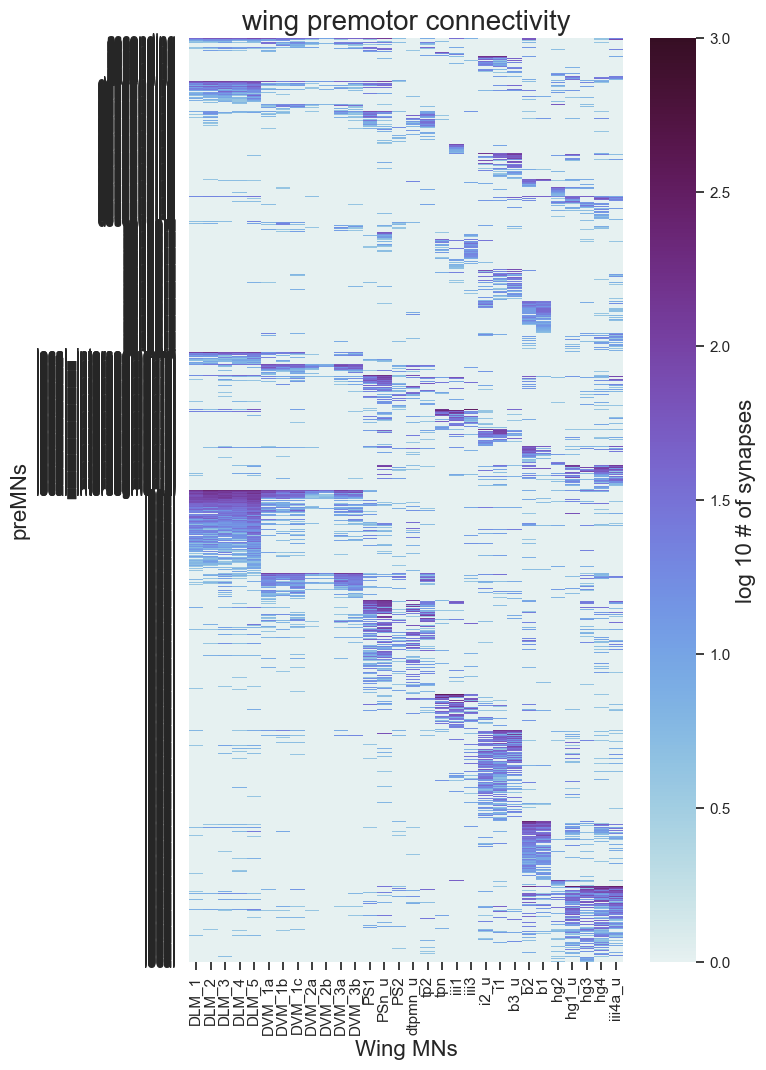

In [11]:
# plotting code for wing premotor connectome
source = multi_df

fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense

log_values = np.log10(source +1)
pmn_ids = source.index.get_level_values(level='cell_class').to_list()
mn_ids = source.columns.to_list()
ax = sns.heatmap(log_values, vmin = 0, vmax = 3, xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
plt.title('wing premotor connectivity', size = 20)
cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('preMNs', size = 16)

plt.show()

In [12]:
# plot proportions from each cell class
df_by_cell_class = multi_df.groupby(level='cell_class').sum().T.rename_axis('MN_label').reset_index()

dict_syn = dict(zip(properties_df.MN_label, properties_df.synapses_include_fragments))

df_by_cell_class['synapses_with_fragments'] = df_by_cell_class.MN_label.map(dict_syn)

# dataframe of proportions for plotting
df_by_cell_class_proportions = df_by_cell_class[['local','local_intersegmental','descending','sensory','ascending']].divide(df_by_cell_class.synapses_with_fragments, axis=0)


/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_55510/347351907.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_by_cell_class = multi_df.groupby(level='cell_class').sum().T.rename_axis('MN_label').reset_index()


In [13]:
df_by_cell_class_proportions.index = df_by_cell_class['MN_label']
df_by_cell_class_proportions['fragment'] = df_by_cell_class_proportions.apply(
    lambda x: 1 - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)


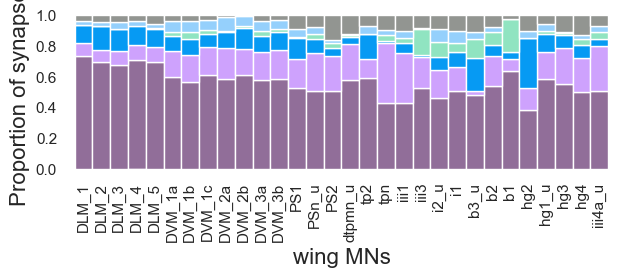

In [14]:
source = df_by_cell_class_proportions

colors_cell_class = ["#916e99","#cea2fd","#069af3","#90e4c1","#95d0fc","#929591", "#650021"]
cmap_cell_class = sns.set_palette(sns.color_palette(colors_cell_class))

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(7, 2)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

plt.show()

In [15]:
# for all wing MNs combined
df_by_cell_class['fragment'] = df_by_cell_class.apply(
    lambda x: x['synapses_with_fragments'] - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)

df_total = df_by_cell_class[['local','local_intersegmental','descending','sensory','ascending','fragment']].sum().divide(df_by_cell_class.synapses_with_fragments.sum(), axis=0) # right order


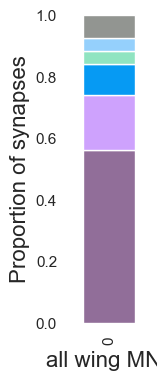

In [16]:
# plot for all wing MNs combined
source = pd.DataFrame(df_total).T

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(1, 4)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("all wing MNs", fontsize = 16)
plt.box(on = False)

plt.show()

In [17]:
df_total

cell_class
local                   0.561443
local_intersegmental    0.177318
descending              0.101968
sensory                 0.043088
ascending               0.041072
fragment                0.075112
dtype: float64

In [18]:
# cosine similarity of MNs based on preMN input

In [19]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    return clustered_order


In [20]:
def organize_by_cos_short(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[:,clustered_order]
    sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
    
    return clustered_order

In [21]:
def organize_by_cos_long(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[clustered_order,:]
    sim_mat = cosine_similarity(reordered_df.to_numpy())
    
    
    return reordered_df

In [23]:
syn_df = pd.read_pickle('pkls/syanpse_positions_wing_v604.pkl')
syn_df.head()

,pre_pt_root_id,post_pt_root_id,pre_pt_position,post_pt_position
1,648518346481006938,648518346470491902,"[23027, 124385, 1028]","[23007, 124409, 1029]"
2,648518346481006938,648518346470491902,"[23045, 124407, 1025]","[23029, 124447, 1025]"
3,648518346481006938,648518346471876251,"[23069, 124559, 993]","[23029, 124571, 994]"
4,648518346481006938,648518346471876251,"[23027, 124591, 967]","[23043, 124563, 969]"
5,648518346479748246,648518346492384195,"[23021, 123919, 930]","[22995, 123945, 931]"


In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

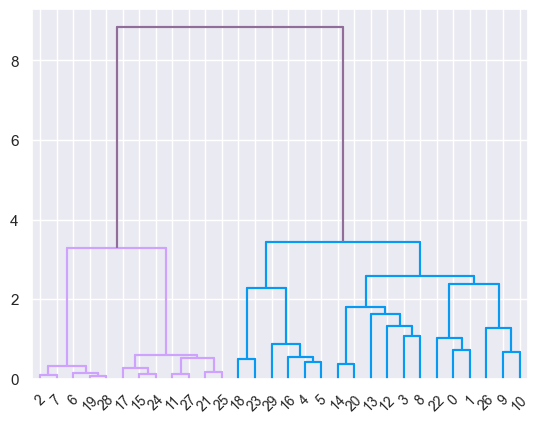

In [28]:
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.post_pt_root_id)
clustered_order = organize_by_cos_short(syn_df)
adj_ordered = adj.iloc[:,clustered_order]

In [29]:
dict_mn = dict(zip(properties_df.MN_id, properties_df.MN_label))
adj_ordered.rename(columns=dict_mn, inplace=True)
mn_ids = adj_ordered.columns


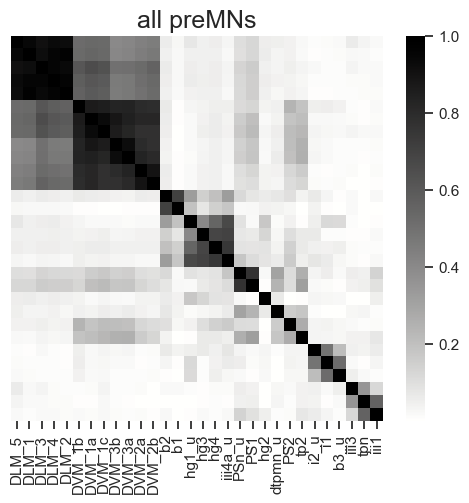

In [30]:
sim_mat = cosine_similarity(adj_ordered.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, xticklabels = mn_ids, yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)

plt.show()

In [31]:
# plot distributions of module preference according to cell class 
# need to create a dataframe where each row contains a unique preMN ID, its cell class, and the fraction of its output onto a single motor cluster, and total # of MN synapses

In [42]:
# motor clusters
cluster_dict = {
"DLM_clu" : ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5'],
"DVM_clu" : ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b'],
"tension_clu" : ['PS1','PS2','dtpmn_u','tp2'],
"steerA_clu" : ['tpn','iii1','iii3'],
"steerB_clu" : ['i2_u','i1','b3_u'],
"steerC_clu" : ['b2','b1'],
"hg2_clu" : ['hg2'],
"steerD_clu" : ['hg1_u','hg3','hg4','iii4a_u']
}
flat_dict = {val:key for key, lst in cluster_dict.items() for val in lst}

In [48]:
properties_df['cluster'] = properties_df.MN_label.map(flat_dict)
properties_df = properties_df.rename(columns={'MN_id':'post_pt_root_id'})

In [51]:
syn_df = syn_df.merge(properties_df[['post_pt_root_id','cluster']])

In [59]:
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.cluster)
adj.head()

cluster,DLM_clu,DVM_clu,hg2_clu,steerA_clu,steerB_clu,steerC_clu,steerD_clu,tension_clu
pre_pt_root_id,,,,,,,,
648518346459413252,0,0,0,1,0,38,0,0
648518346459520004,138,72,0,0,0,0,0,38
648518346459550468,49,0,0,0,0,2,3,0
648518346459573508,0,1,0,5,84,0,1,1
648518346459589380,1,0,0,0,27,0,1,0


In [75]:
pref_df = pd.DataFrame(adj.sum(axis=1).reset_index(name='MN_syn'))
pref_df = pref_df.merge(pd.DataFrame(adj.max(axis=1).reset_index(name='top_syn')))
pref_df['proportion'] = pref_df.top_syn / pref_df.MN_syn
pref_df = pref_df.merge(multi_df.reset_index()[['pre_pt_root_id','cell_class']])

pref_df['log_syn'] = np.log(pref_df['MN_syn'])
pref_df['syn_bin'] = pd.cut(pref_df.log_syn,10) # bin number of MN synapses for plotting by hue

pref_df.head()

,pre_pt_root_id,MN_syn,top_syn,proportion,cell_class,log_syn,syn_bin
0,648518346459413252,39,38,0.974359,local,3.663562,"(2.955, 3.693]"
1,648518346459520004,248,138,0.556452,descending,5.513429,"(5.171, 5.909]"
2,648518346459550468,54,49,0.907407,local,3.988984,"(3.693, 4.432]"
3,648518346459573508,92,84,0.913043,local,4.521789,"(4.432, 5.171]"
4,648518346459589380,29,27,0.931034,local,3.367296,"(2.955, 3.693]"


/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/

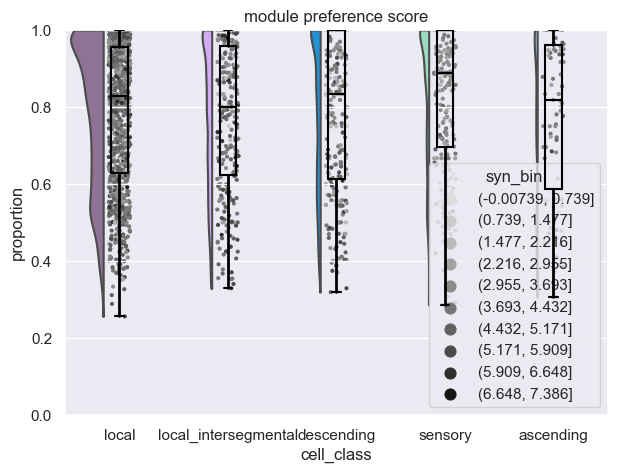

In [78]:
ort = 'v' # vertical or horizontally oriented plot
dx = "cell_class"
dy = "proportion"
class_order = ['local', 'local_intersegmental','descending','sensory','ascending']
plot_df = pref_df

pal = sns.color_palette("Greys", n_colors=12)
pal = pal[2:]

f, ax = plt.subplots(figsize=(7, 5))

ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, bw = .2, cut = 0.,
scale = "count", width = .6, inner = None, orient = ort, order=class_order)

ax=sns.stripplot( x = dx, y = dy, data = plot_df, hue="syn_bin", palette = pal,
size = 3, jitter = 1, zorder = 0, orient = ort, order=class_order) # edgecolor = "white"

ax=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort, order=class_order)
plt.ylim(0,1)
plt.title("module preference score")
plt.show()